# LoopVerse 2025 — EuroSAT Land Cover Classification

## Problem Statement: EuroSAT Land Cover Classification with Deep Learning

**Background:**
Satellite imagery plays a crucial role in environmental monitoring, urban planning, and disaster response. The EuroSAT dataset contains multispectral Sentinel‑2 satellite image tiles of size 64×64 pixels across 10 land-use classes such as Forest, Urban, Water, Agriculture, and others.

**Task:**
Develop a complete machine learning pipeline that can classify each tile into its correct land-cover type. The dataset is raw, noisy, and inconsistent — requiring cleaning and preprocessing before building the model.

**Key Requirements:**
1. Data Cleaning and Preprocessing (Handle mixed formats, remove corrupted images, apply filtering)
2. Feature Extraction (Color histograms, edges, textures)
3. CNN from Scratch (No pretrained models)
4. Performance Improvement (Data augmentation, optimization techniques)
5. Model Evaluation (Confusion matrix, metrics, CSV predictions)
6. Analysis and Visualization

## 1. Environment Setup and Library Imports

Import all required libraries including TensorFlow, OpenCV, PIL, scikit-learn, matplotlib, and other dependencies.

In [33]:
!pip install opencv-python


In [34]:
!pip install tensorflow

In [35]:
!pip install --upgrade pip setuptools wheel

In [36]:
!pip install tensorflow

In [37]:
!pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [38]:
import os
import shutil
import sys
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Install missing packages if needed (commented out for local environment)
# For local installation: pip install matplotlib scikit-learn tqdm tensorflow opencv-python pillow
try:
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
except ImportError as e:
    print(f"Missing package: {e}")
    print("Please install missing packages using:")
    print("pip install matplotlib scikit-learn tqdm tensorflow opencv-python pillow")
    sys.exit(1)

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tqdm import tqdm

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0
OpenCV version: 4.12.0


## 2. Configuration and Data Path Setup

Define user-configurable variables including DATA_ROOT path, image size, batch size, epochs, random seed, and other hyperparameters.

In [39]:
# ------------------------------
# User-configurable variables
# ------------------------------
DATA_ROOT = r"C:\Users\admin\Downloads\EuroSAT_RGB (2)"  # Local path to dataset
# Which folder to use for CNN (RGB is typical). If you want to use multispectral change to 'EuroSAT_MS'.
DATASET_FOLDER = 'EuroSAT_RGB'  # or 'EuroSAT_MS'
IMG_SIZE = (64, 64)
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 30
RANDOM_SEED = 42
MIN_VALID_IMAGES_PER_CLASS = 10
CORRUPTED_FOLDER_NAME = 'corrupted'

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Configuration set:")
print(f"Data Root: {DATA_ROOT}")
print(f"Dataset Folder: {DATASET_FOLDER}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Random Seed: {RANDOM_SEED}")

Configuration set:
Data Root: C:\Users\admin\Downloads\EuroSAT_RGB (2)
Dataset Folder: EuroSAT_RGB
Image Size: (64, 64)
Batch Size: 32
Epochs: 30
Random Seed: 42


## 3. Image Reading and Corruption Detection Utilities

Implement robust image reading functions that handle multiple formats (.jpg, .png, .tif) and corruption detection based on black pixel threshold and variance analysis.

In [40]:
def read_image(path, target_size=IMG_SIZE, channels=CHANNELS):
    """Read image from path. Handles jpg/png/tif and multi-band tif.
    Returns image as uint8 HxWxC or None if unreadable.
    """
    try:
        # Try Pillow first
        img = Image.open(path)
        img = img.convert('RGB')  # keep 3 channels
        img = img.resize(target_size, Image.BICUBIC)
        arr = np.array(img)
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        if arr.shape[2] < channels:
            # pad channels if necessary
            pad = channels - arr.shape[2]
            arr = np.concatenate([arr] + [arr[..., :1]]*pad, axis=2)
        if arr.shape[2] > channels:
            arr = arr[..., :channels]
        return arr
    except Exception:
        # fallback to cv2
        try:
            arr = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
            if arr is None:
                return None
            # If multi-band (e.g., shape (H, W, >3)), keep first 3
            if arr.ndim == 2:
                arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
            elif arr.shape[2] > 3:
                arr = arr[:, :, :3]
            arr = cv2.resize(arr, target_size, interpolation=cv2.INTER_CUBIC)
            arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
            return arr
        except Exception:
            return None


def is_corrupted(img_arr, black_threshold=0.6, zero_var_threshold=1e-6):
    """Detect corrupted images: too many near-black pixels or very low variance."""
    if img_arr is None:
        return True
    # Too many near-zero pixels
    gray = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
    frac_black = np.mean(gray < 5)
    if frac_black > black_threshold:
        return True
    # Extremely low variance
    if np.var(img_arr) < zero_var_threshold:
        return True
    return False

print("Image reading and corruption detection utilities defined!")

Image reading and corruption detection utilities defined!


## 4. Data Cleaning and Preprocessing Pipeline

Process the EuroSAT dataset by reading images, detecting and moving corrupted files, applying Gaussian denoising filter, and organizing clean data for training.

In [41]:
def prepare_dataset(data_root, dataset_folder):
    """Process the EuroSAT dataset with cleaning and preprocessing."""
    dataset_path = Path(data_root) / dataset_folder
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset folder not found: {dataset_path}")

    classes = [p.name for p in dataset_path.iterdir() if p.is_dir()]
    classes.sort()
    print(f"Found classes ({len(classes)}): {classes}")

    X = []
    y = []
    image_paths = []
    corrupted_dir = dataset_path / CORRUPTED_FOLDER_NAME
    corrupted_dir.mkdir(exist_ok=True)

    for cls in classes:
        cls_dir = dataset_path / cls
        files = list(cls_dir.glob('*'))
        if len(files) == 0:
            continue
        
        print(f"Processing {cls}: {len(files)} files found")
        
        for f in tqdm(files, desc=f'Processing {cls}', unit='img'):
            if f.is_dir():
                continue
            arr = read_image(f)
            if is_corrupted(arr):
                # move corrupted to subfolder
                try:
                    # maintain class subfolder under corrupted
                    target = corrupted_dir / cls
                    target.mkdir(exist_ok=True)
                    shutil.move(str(f), str(target / f.name))
                except Exception:
                    pass
                continue
            # Apply denoising filter (Gaussian)
            denoised = cv2.GaussianBlur(arr, (3, 3), 0)
            X.append(denoised)
            y.append(cls)
            image_paths.append(str(f))

    X = np.array(X, dtype=np.float32)
    y = np.array(y)
    print(f"Loaded images: {len(X)} (corrupted moved to: {corrupted_dir})")
    return X, y, image_paths, classes

print("Data preprocessing function defined!")

Data preprocessing function defined!


## 5. Feature Extraction and Visualization

Extract color histograms and edge histograms from images, create visualization functions to display sample images with their feature distributions across different classes.

In [42]:
def extract_color_histograms(images, bins=32):
    """Extract color histograms from images - returns array (N, bins*3)"""
    feats = []
    for img in images:
        chans = cv2.split(img.astype('uint8'))
        hist = np.concatenate([cv2.calcHist([c], [0], None, [bins], [0, 256]).flatten() for c in chans])
        hist = hist / np.sum(hist)
        feats.append(hist)
    return np.array(feats)


def extract_edge_histogram(images, bins=32):
    """Extract edge histograms using Canny edge detection"""
    feats = []
    for img in images:
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        hist = cv2.calcHist([edges], [0], None, [bins], [0, 256]).flatten()
        hist = hist / (np.sum(hist) + 1e-8)
        feats.append(hist)
    return np.array(feats)


def visualize_feature_distributions(X, y, classes, n_samples=5):
    """Show sample images and their histograms (color + edges)"""
    fig, axs = plt.subplots(3, n_samples, figsize=(3*n_samples, 9))
    for i in range(n_samples):
        idx = np.random.randint(0, len(X))
        img = X[idx].astype('uint8')
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
        axs[0, i].set_title(y[idx])

        chans = cv2.split(img)
        for c_i, c in enumerate(chans):
            axs[1, i].plot(cv2.calcHist([c], [0], None, [32], [0,256]).flatten(), alpha=0.7)
        axs[1, i].set_title('Color hist')

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        axs[2, i].imshow(edges, cmap='gray')
        axs[2, i].axis('off')
        axs[2, i].set_title('Edges')
    plt.tight_layout()
    plt.show()

print("Feature extraction functions defined!")

Feature extraction functions defined!


## 6. Label Encoding and Data Splitting

Convert class names to numerical indices, perform stratified train-validation split, and set up data generators with augmentation for training.

In [43]:
def encode_labels(y, classes):
    """Convert class names to numerical indices"""
    class_to_idx = {c: i for i, c in enumerate(classes)}
    y_idx = np.array([class_to_idx[cls] for cls in y])
    return y_idx, class_to_idx

print("Label encoding function defined!")

Label encoding function defined!


## 7. Baseline CNN Model Architecture

Build a CNN from scratch with 3 convolutional blocks, each containing Conv2D, BatchNormalization, ReLU activation, MaxPooling, and Dropout layers, followed by dense layers.

In [44]:
def build_baseline_cnn(input_shape=(64,64,3), num_classes=10):
    """Build baseline CNN model from scratch"""
    model = models.Sequential()
    
    # Conv block 1
    model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Conv block 2
    model.add(layers.Conv2D(64, (3,3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # Conv block 3
    model.add(layers.Conv2D(128, (3,3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

print("Baseline CNN model function defined!")

Baseline CNN model function defined!


## 8. Training Helpers and Visualization Functions

Functions for plotting training history and visualizing model activations.

In [45]:
def plot_history(history, title_suffix=''):
    """Plot training and validation accuracy and loss curves"""
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].plot(history.history['loss'], label='train_loss')
    axes[0].plot(history.history['val_loss'], label='val_loss')
    axes[0].legend(); axes[0].set_title('Loss '+title_suffix)

    axes[1].plot(history.history['accuracy'], label='train_acc')
    axes[1].plot(history.history['val_accuracy'], label='val_acc')
    axes[1].legend(); axes[1].set_title('Accuracy '+title_suffix)
    plt.show()


def visualize_activations(model, img_tensor, layer_indices=[0,3,6]):
    """Visualize intermediate layer activations"""
    # img_tensor: 1xHxWxC float32
    outputs = [model.layers[i].output for i in layer_indices if i < len(model.layers)]
    if not outputs:
        print('No layers selected or indices out of range')
        return
    act_model = models.Model(inputs=model.input, outputs=outputs)
    acts = act_model.predict(img_tensor)
    for i, act in enumerate(acts):
        n_maps = min(act.shape[-1], 6)
        fig, axs = plt.subplots(1, n_maps, figsize=(12,2))
        for j in range(n_maps):
            axs[j].imshow(act[0,:,:,j], cmap='viridis')
            axs[j].axis('off')
        plt.suptitle(f'Layer {layer_indices[i]} activations')
        plt.show()

print("Training helper functions defined!")

Training helper functions defined!


## 9. Load and Preprocess Dataset

Execute the data loading pipeline and extract features for analysis.

In [46]:
# Load and preprocess the dataset
print("Loading and preprocessing EuroSAT dataset...")
X, y, image_paths, classes = prepare_dataset(r"C:\Users\admin\Downloads\EuroSAT_RGB (2)\EuroSAT_RGB", DATASET_FOLDER)

# Normalize to [0,1]
X = X / 255.0

print(f"Dataset loaded successfully!")
print(f"Number of images: {len(X)}")
print(f"Image shape: {X[0].shape}")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(f"\nClass distribution:")
for cls, count in class_distribution.items():
    print(f"  {cls}: {count} images")

Loading and preprocessing EuroSAT dataset...
Found classes (11): ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'corrupted']
Processing AnnualCrop: 3000 files found


Processing AnnualCrop: 100%|██████████| 3000/3000 [00:08<00:00, 364.95img/s]


Processing Forest: 3000 files found


Processing Forest: 100%|██████████| 3000/3000 [00:07<00:00, 397.30img/s]


Processing HerbaceousVegetation: 3000 files found


Processing HerbaceousVegetation: 100%|██████████| 3000/3000 [00:07<00:00, 381.09img/s]


Processing Highway: 2500 files found


Processing Highway: 100%|██████████| 2500/2500 [00:06<00:00, 399.55img/s]


Processing Industrial: 2500 files found


Processing Industrial: 100%|██████████| 2500/2500 [00:07<00:00, 333.69img/s]


Processing Pasture: 2000 files found


Processing Pasture: 100%|██████████| 2000/2000 [00:30<00:00, 66.50img/s] 


Processing PermanentCrop: 2500 files found


Processing PermanentCrop:  28%|██▊       | 702/2500 [00:14<00:37, 48.09img/s]


KeyboardInterrupt: 

Extracting color histograms and edge histograms...
Color features shape: (27000, 96)
Edge features shape: (27000, 32)

Visualizing sample images and their features...


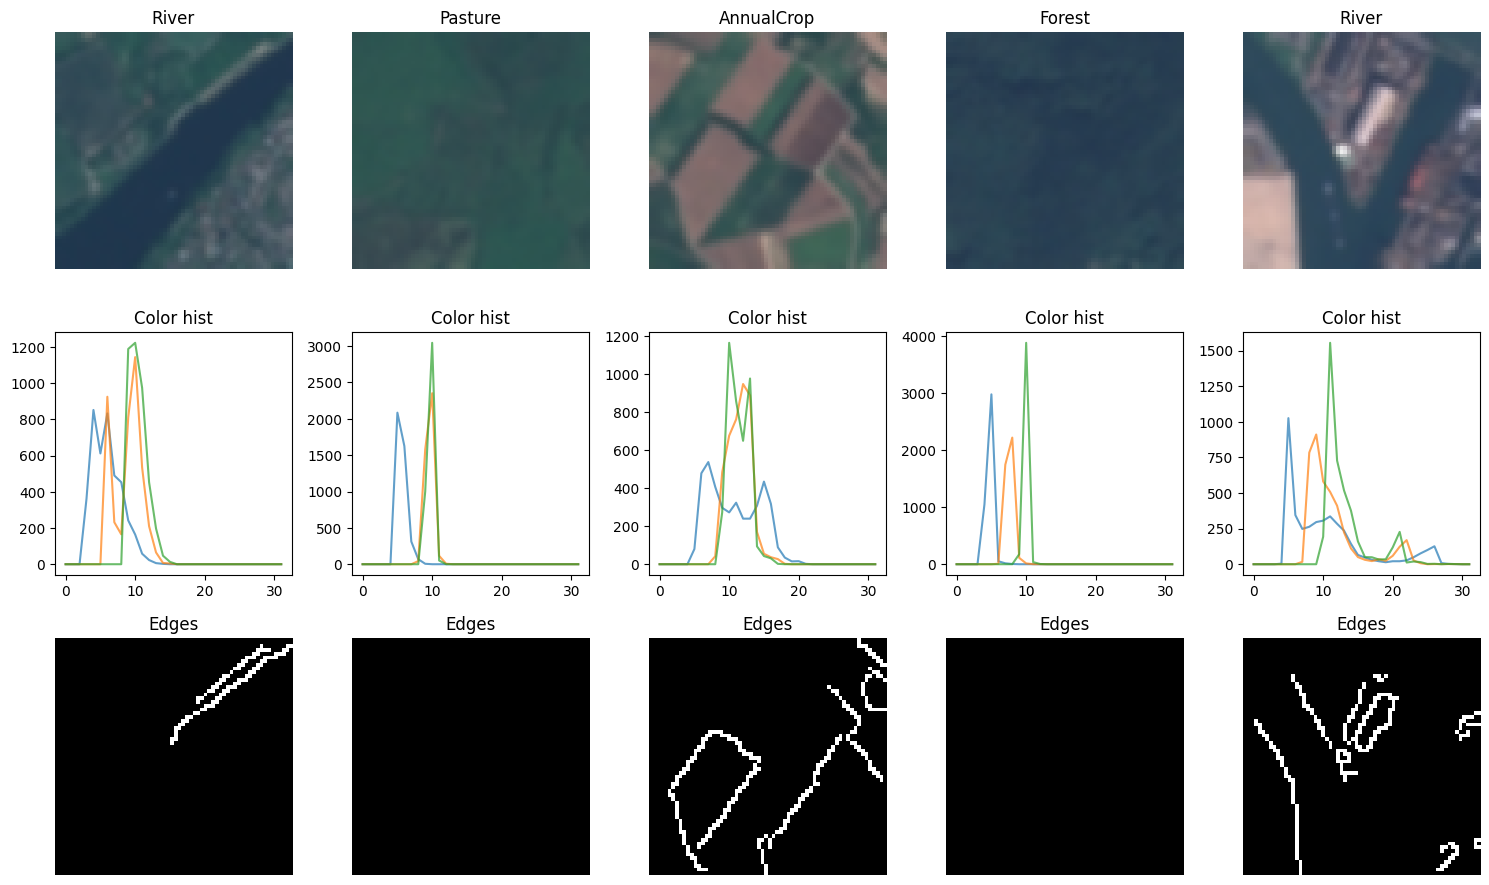

In [ ]:
# Feature extraction: color hist and edge hist (for analysis)
print('Extracting color histograms and edge histograms...')
color_feats = extract_color_histograms((X*255).astype('uint8'))
edge_feats = extract_edge_histogram((X*255).astype('uint8'))

print(f"Color features shape: {color_feats.shape}")
print(f"Edge features shape: {edge_feats.shape}")

# Visualize feature distributions
print("\nVisualizing sample images and their features...")
visualize_feature_distributions((X*255).astype('uint8'), y, classes, n_samples=5)

## 10. Data Splitting and Preparation for Training

Split data into training and validation sets with data augmentation setup.

In [ ]:
# Label encoding and train/validation split
y_idx, class_to_idx = encode_labels(y, classes)
num_classes = len(classes)

print(f"Class to index mapping: {class_to_idx}")

X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    X, y_idx, image_paths, test_size=0.2, random_state=RANDOM_SEED, stratify=y_idx)

print(f'Train samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

# Data augmentation setup
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train, 
    tf.keras.utils.to_categorical(y_train, num_classes), 
    batch_size=BATCH_SIZE
)
val_generator = val_datagen.flow(
    X_val, 
    tf.keras.utils.to_categorical(y_val, num_classes), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print("Data generators created with augmentation!")

Class to index mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Train samples: 21600
Validation samples: 5400
Data generators created with augmentation!


## 11. Baseline Model Training

Build, compile, and train the baseline CNN model with callbacks for monitoring.

In [ ]:
# Build baseline model
model = build_baseline_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNELS), num_classes=num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model architecture
model.summary()

# Setup callbacks
output_dir = Path(DATA_ROOT).parent  # Save outputs in ML folder
checkpoint_path = output_dir / 'best_model_baseline.h5'
cb_list = [
    callbacks.ModelCheckpoint(str(checkpoint_path), monitor='val_accuracy', 
                            save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=6, 
                          restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                              patience=3, verbose=1)
]

print("Model created and callbacks configured!")
print(f"Model will be saved to: {checkpoint_path}")

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,195,146 (8.37 MB)

 Trainable params: 2,194,186 (8.37 MB)

 Non-trainable params: 960 (3.75 KB)

Model created and callbacks configured!
Model will be saved to: C:\Users\admin\Downloads\best_model_baseline.h5


In [ ]:
# Train the baseline model
print("Starting baseline model training...")
history = model.fit(train_generator, 
                   epochs=EPOCHS, 
                   validation_data=val_generator, 
                   callbacks=cb_list)

print("Baseline model training completed!")

Starting baseline model training...


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.1185 - loss: 2.5267
Epoch 1: val_accuracy improved from None to 0.12833, saving model to C:\Users\admin\Downloads\best_model_baseline.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 180s 261ms/step - accuracy: 0.1236 - loss: 2.4613 - val_accuracy: 0.1283 - val_loss: 8.4597 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.1213 - loss: 2.3715
Epoch 2: val_accuracy did not improve from 0.12833
675/675 ━━━━━━━━━━━━━━━━━━━━ 166s 246ms/step - accuracy: 0.1238 - loss: 2.3435 - val_accuracy: 0.0957 - val_loss: 16.7565 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.1290 - loss: 2.2988
Epoch 3: val_accuracy did not improve from 0.12833
675/675 ━━━━━━━━━━━━━━━━━━━━ 168s 249ms/step - accuracy: 0.1296 - loss: 2.2987 - val_accuracy: 0.1111 - val_loss: 13.0196 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.1292 - loss: 2.2820
Epoch 4: val_accuracy did not improve from 0.12833

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
675/675 ━━━━━━━━━━━━━━━━━━━━ 148s 219ms/step - accuracy: 0.1264 - los

675/675 ━━━━━━━━━━━━━━━━━━━━ 170s 252ms/step - accuracy: 0.1380 - loss: 2.2552 - val_accuracy: 0.1833 - val_loss: 2.6545 - learning_rate: 5.0000e-04
Epoch 13/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.1348 - loss: 2.2544
Epoch 13: val_accuracy did not improve from 0.18333
675/675 ━━━━━━━━━━━━━━━━━━━━ 156s 231ms/step - accuracy: 0.1360 - loss: 2.2523 - val_accuracy: 0.0926 - val_loss: 3.6053 - learning_rate: 5.0000e-04
Epoch 14/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.1366 - loss: 2.2536
Epoch 14: val_accuracy did not improve from 0.18333

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
675/675 ━━━━━━━━━━━━━━━━━━━━ 145s 214ms/step - accuracy: 0.1364 - loss: 2.2492 - val_accuracy: 0.0926 - val_loss: 3.9421 - learning_rate: 5.0000e-04
Epoch 15/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1410 - loss: 2.2430
Epoch 15: val_accuracy did not improve from 0.18333
675/675 ━━━━━━━━━━━━━━━━━━━━ 155s 230ms/step - accur

## 12. Training History Visualization

Plot training and validation accuracy and loss curves to analyze model performance.

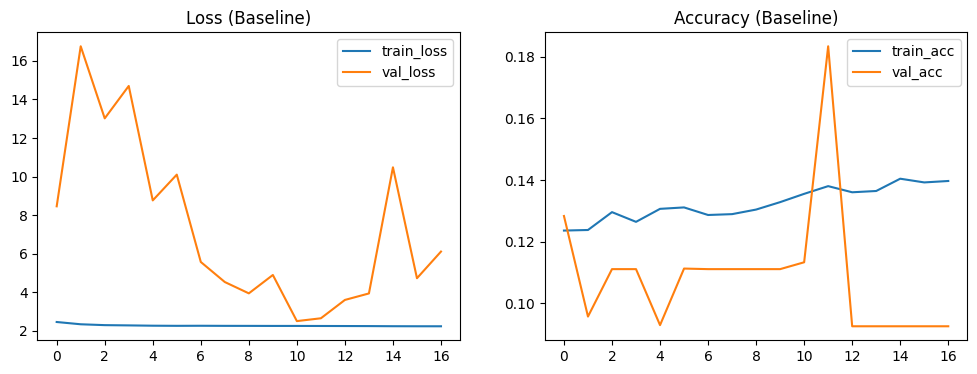


Baseline Model Final Metrics:
Training Accuracy: 0.1397
Validation Accuracy: 0.0926
Training Loss: 2.2397
Validation Loss: 6.1129


In [ ]:
# Plot training history for baseline model
plot_history(history, title_suffix='(Baseline)')

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nBaseline Model Final Metrics:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

## 13. Baseline Model Evaluation and Metrics

Generate predictions, create confusion matrix, and save results to CSV.

In [ ]:
# Evaluate baseline model on validation set
val_preds = model.predict(X_val)
y_pred = np.argmax(val_preds, axis=1)

print('Baseline Model Classification Report:')
print(classification_report(y_val, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(f'\nConfusion Matrix Shape: {cm.shape}')
print('Confusion matrix:')
print(cm)

# Save predictions to CSV
df = pd.DataFrame({'image_id': paths_val, 'predicted_label': [classes[i] for i in y_pred]})
csv_out = output_dir / 'predictions_baseline.csv'
df.to_csv(csv_out, index=False)
print(f'\nSaved baseline predictions to: {csv_out}')

169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
Baseline Model Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.11      1.00      0.20       600
              Forest       0.00      0.00      0.00       600
HerbaceousVegetation       0.00      0.00      0.00       600
             Highway       0.00      0.00      0.00       500
          Industrial       0.92      0.02      0.05       500
             Pasture       0.00      0.00      0.00       400
       PermanentCrop       0.00      0.00      0.00       500
         Residential       0.00      0.00      0.00       600
               River       0.00      0.00      0.00       500
             SeaLake       0.00      0.00      0.00       600

            accuracy                           0.11      5400
           macro avg       0.10      0.10      0.02      5400
        weighted avg       0.10      0.11      0.03      5400


Confusion Matrix Shape: (10, 10)
Confusion matri

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

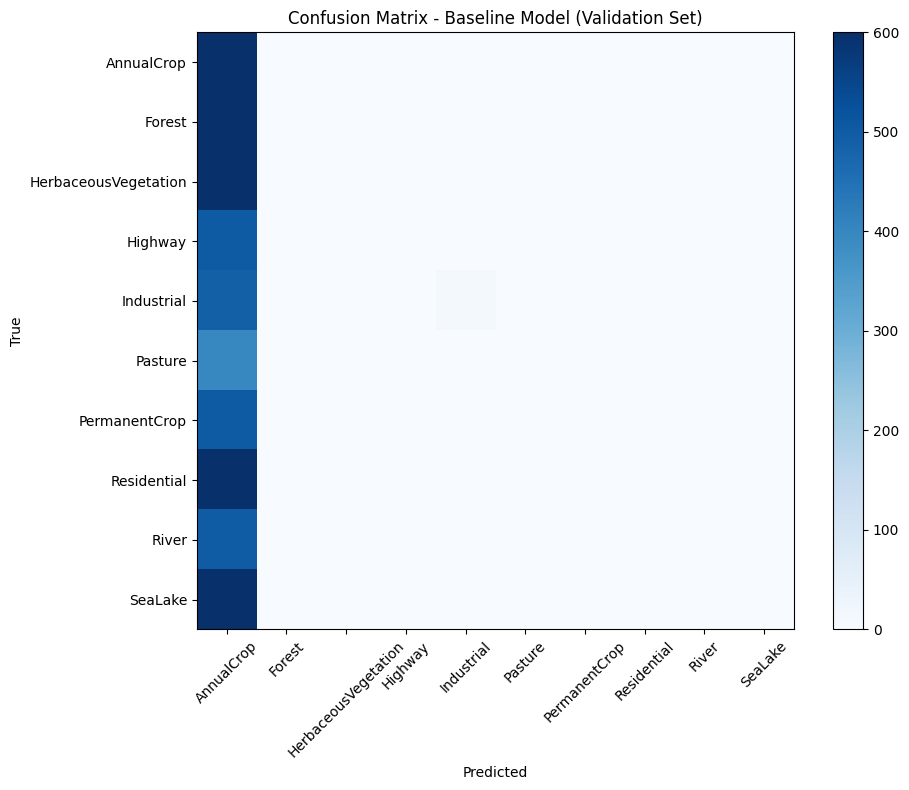

Confusion matrix saved to: C:\Users\admin\Downloads\confusion_matrix_baseline.png
Baseline model saved to: C:\Users\admin\Downloads\loopverse_baseline_model.h5


In [ ]:
# Plot and save confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Baseline Model (Validation Set)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# Save confusion matrix plot
cm_path = output_dir / 'confusion_matrix_baseline.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to: {cm_path}")

# Save baseline model
model_path = output_dir / 'loopverse_baseline_model.h5'
model.save(model_path)
print(f'Baseline model saved to: {model_path}')

## 14. Improved CNN Model Implementation

Build an enhanced CNN architecture with deeper layers, adjusted dropout rates, and learning rate scheduling for better performance.

In [ ]:
print('Building improved model (deeper + different dropout + LR schedule)')

def build_improved_cnn(input_shape, num_classes):
    """Build improved CNN with deeper architecture and tuned parameters"""
    inp = layers.Input(shape=input_shape)
    
    # First conv block (deeper)
    x = layers.Conv2D(32, (3,3), padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Second conv block (deeper)
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    # Third conv block
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.35)(x)

    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=inp, outputs=out)

# Build improved model
improved = build_improved_cnn((IMG_SIZE[0], IMG_SIZE[1], CHANNELS), num_classes)
improved.compile(optimizer=optimizers.Adam(learning_rate=1e-3), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

improved.summary()

Building improved model (deeper + different dropout + LR schedule)


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,342,698 (16.57 MB)

 Trainable params: 4,341,034 (16.56 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Learning rate schedule callback
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 8 == 0:
        return lr * 0.5
    return lr

lr_cb = callbacks.LearningRateScheduler(scheduler)

# Setup callbacks for improved model
checkpoint_path2 = output_dir / 'best_model_improved.h5'
cb2 = [
    callbacks.ModelCheckpoint(str(checkpoint_path2), monitor='val_accuracy', 
                            save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=8, 
                          restore_best_weights=True, verbose=1),
    lr_cb
]

# Train improved model
print("Starting improved model training...")
history2 = improved.fit(train_generator, 
                       epochs=EPOCHS, 
                       validation_data=val_generator, 
                       callbacks=cb2)

print("Improved model training completed!")

Starting improved model training...
Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.1235 - loss: 2.5843
Epoch 1: val_accuracy improved from None to 0.11259, saving model to C:\Users\admin\Downloads\best_model_improved.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 371s 531ms/step - accuracy: 0.1275 - loss: 2.5230 - val_accuracy: 0.1126 - val_loss: 41.6161 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.1284 - loss: 2.3754
Epoch 2: val_accuracy did not improve from 0.11259
675/675 ━━━━━━━━━━━━━━━━━━━━ 340s 503ms/step - accuracy: 0.1263 - loss: 2.3607 - val_accuracy: 0.0926 - val_loss: 54.1301 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.1273 - loss: 2.3271
Epoch 3: val_accuracy did not improve from 0.11259
675/675 ━━━━━━━━━━━━━━━━━━━━ 332s 492ms/step - accuracy: 0.1258 - loss: 2.3191 - val_accuracy: 0.1111 - val_loss: 34.8753 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.1312 - loss: 2.2926
Epoch 4: val_accuracy did not improve from 0.11259
675/675 ━━━━━━━━━━━━━━━━━━━━ 325s 482ms/step - accuracy: 0.1303 - loss: 2.2950 - val_accuracy: 0.1111 - val_loss: 12.7864 - learning_rate: 0.0010

675/675 ━━━━━━━━━━━━━━━━━━━━ 328s 485ms/step - accuracy: 0.1293 - loss: 2.2892 - val_accuracy: 0.1313 - val_loss: 3.0368 - learning_rate: 0.0010
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.1338 - loss: 2.2796
Epoch 7: val_accuracy did not improve from 0.13130
675/675 ━━━━━━━━━━━━━━━━━━━━ 331s 490ms/step - accuracy: 0.1337 - loss: 2.2786 - val_accuracy: 0.1113 - val_loss: 21.1714 - learning_rate: 0.0010
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.1273 - loss: 2.2802
Epoch 8: val_accuracy did not improve from 0.13130
675/675 ━━━━━━━━━━━━━━━━━━━━ 333s 492ms/step - accuracy: 0.1292 - loss: 2.2814 - val_accuracy: 0.1111 - val_loss: 6.6692 - learning_rate: 0.0010
Epoch 9/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.1281 - loss: 2.2731
Epoch 9: val_accuracy did not improve from 0.13130
675/675 ━━━━━━━━━━━━━━━━━━━━ 343s 508ms/step - accuracy: 0.1300 - loss: 2.2682 - val_accuracy: 0.1111 - val_loss: 7.5326 - learning_rate: 5.0000e-0

675/675 ━━━━━━━━━━━━━━━━━━━━ 283s 420ms/step - accuracy: 0.1346 - loss: 2.2529 - val_accuracy: 0.1369 - val_loss: 2.2930 - learning_rate: 2.5000e-04
Epoch 20/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.1443 - loss: 2.2454
Epoch 20: val_accuracy did not improve from 0.13685
675/675 ━━━━━━━━━━━━━━━━━━━━ 320s 474ms/step - accuracy: 0.1381 - loss: 2.2522 - val_accuracy: 0.1235 - val_loss: 2.2908 - learning_rate: 2.5000e-04
Epoch 21/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.1432 - loss: 2.2509
Epoch 21: val_accuracy did not improve from 0.13685
675/675 ━━━━━━━━━━━━━━━━━━━━ 300s 444ms/step - accuracy: 0.1413 - loss: 2.2522 - val_accuracy: 0.0844 - val_loss: 2.2890 - learning_rate: 2.5000e-04
Epoch 22/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.1411 - loss: 2.2504
Epoch 22: val_accuracy improved from 0.13685 to 0.14944, saving model to C:\Users\admin\Downloads\best_model_improved.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 316s 468ms/step - accuracy: 0.1364 - loss: 2.2502 - val_accuracy: 0.1494 - val_loss: 2.2971 - learning_rate: 2.5000e-04
Epoch 23/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.1379 - loss: 2.2492
Epoch 23: val_accuracy did not improve from 0.14944
675/675 ━━━━━━━━━━━━━━━━━━━━ 295s 437ms/step - accuracy: 0.1387 - loss: 2.2516 - val_accuracy: 0.1124 - val_loss: 2.2754 - learning_rate: 2.5000e-04
Epoch 24/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.1355 - loss: 2.2499
Epoch 24: val_accuracy did not improve from 0.14944
675/675 ━━━━━━━━━━━━━━━━━━━━ 321s 476ms/step - accuracy: 0.1369 - loss: 2.2486 - val_accuracy: 0.1124 - val_loss: 2.3322 - learning_rate: 2.5000e-04
Epoch 25/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.1348 - loss: 2.2445
Epoch 25: val_accuracy improved from 0.14944 to 0.15093, saving model to C:\Users\admin\Downloads\best_model_improved.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 334s 494ms/step - accuracy: 0.1331 - loss: 2.2471 - val_accuracy: 0.1509 - val_loss: 2.2957 - learning_rate: 1.2500e-04
Epoch 26/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.1354 - loss: 2.2456
Epoch 26: val_accuracy did not improve from 0.15093
675/675 ━━━━━━━━━━━━━━━━━━━━ 366s 541ms/step - accuracy: 0.1350 - loss: 2.2472 - val_accuracy: 0.1326 - val_loss: 2.2631 - learning_rate: 1.2500e-04
Epoch 27/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.1387 - loss: 2.2476
Epoch 27: val_accuracy did not improve from 0.15093
675/675 ━━━━━━━━━━━━━━━━━━━━ 358s 530ms/step - accuracy: 0.1362 - loss: 2.2478 - val_accuracy: 0.1111 - val_loss: 2.2553 - learning_rate: 1.2500e-04
Epoch 28/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.1393 - loss: 2.2486
Epoch 28: val_accuracy did not improve from 0.15093
675/675 ━━━━━━━━━━━━━━━━━━━━ 379s 561ms/step - accuracy: 0.1406 - loss: 2.2480 - val_accuracy: 0.1117 - val_loss: 2.2115 - learnin

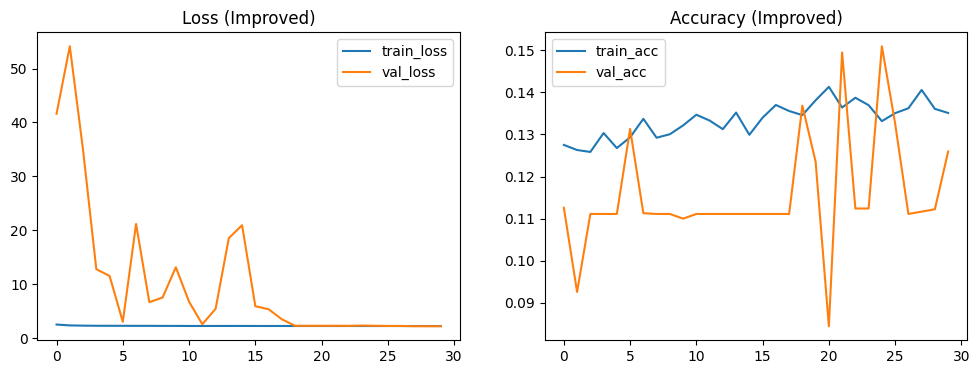


Improved Model Final Metrics:
Training Accuracy: 0.1351
Validation Accuracy: 0.1259
Training Loss: 2.2465
Validation Loss: 2.2003

Comparison with Baseline:
Validation Accuracy Improvement: 0.0333
Validation Loss Improvement: 3.9126


In [ ]:
# Plot improved model training history
plot_history(history2, title_suffix='(Improved)')

# Print final metrics for improved model
final_train_acc2 = history2.history['accuracy'][-1]
final_val_acc2 = history2.history['val_accuracy'][-1]
final_train_loss2 = history2.history['loss'][-1]
final_val_loss2 = history2.history['val_loss'][-1]

print(f"\nImproved Model Final Metrics:")
print(f"Training Accuracy: {final_train_acc2:.4f}")
print(f"Validation Accuracy: {final_val_acc2:.4f}")
print(f"Training Loss: {final_train_loss2:.4f}")
print(f"Validation Loss: {final_val_loss2:.4f}")

# Compare with baseline
print(f"\nComparison with Baseline:")
print(f"Validation Accuracy Improvement: {final_val_acc2 - final_val_acc:.4f}")
print(f"Validation Loss Improvement: {final_val_loss - final_val_loss2:.4f}")

## 15. Performance Comparison and Analysis

Compare baseline and improved models, evaluate metrics, and visualize confusion matrices side-by-side.

169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step
Improved Model Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.13      0.99      0.23       600
              Forest       0.00      0.00      0.00       600
HerbaceousVegetation       0.10      0.12      0.11       600
             Highway       0.00      0.00      0.00       500
          Industrial       0.00      0.00      0.00       500
             Pasture       0.00      0.00      0.00       400
       PermanentCrop       0.00      0.00      0.00       500
         Residential       0.00      0.00      0.00       600
               River       0.00      0.00      0.00       500
             SeaLake       0.15      0.03      0.05       600

            accuracy                           0.13      5400
           macro avg       0.04      0.11      0.04      5400
        weighted avg       0.04      0.13      0.04      5400



C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

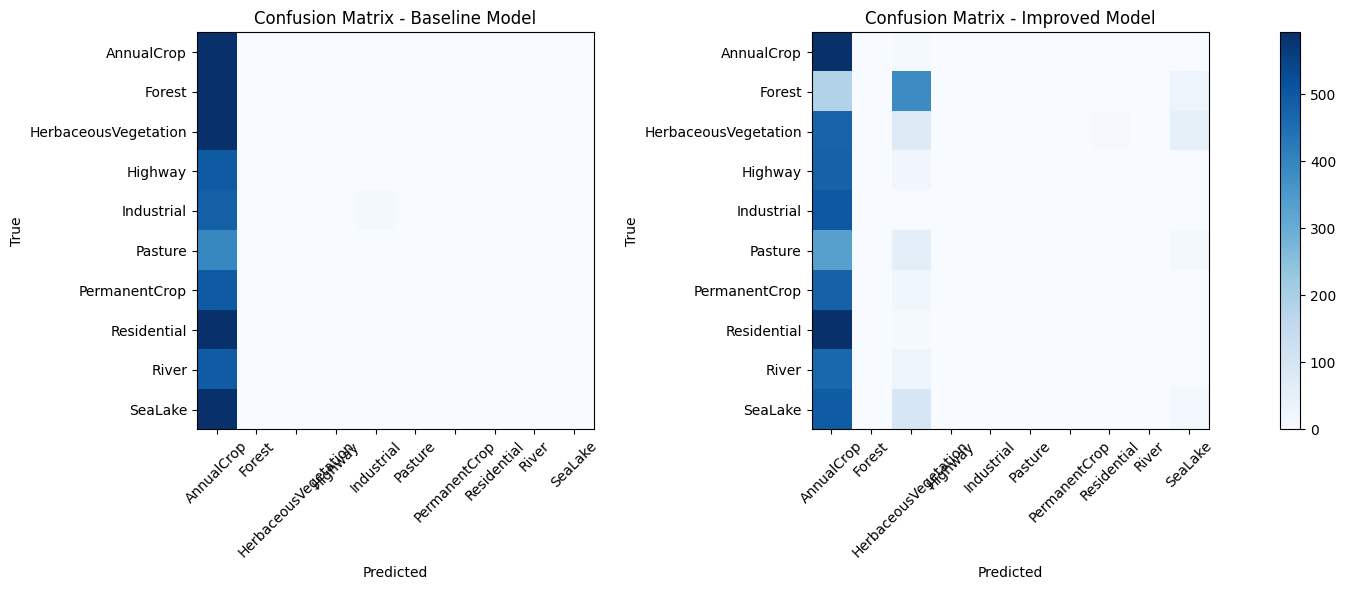

Confusion matrix comparison saved to: C:\Users\admin\Downloads\confusion_matrix_comparison.png


In [ ]:
# Evaluate improved model
val_preds2 = improved.predict(X_val)
y_pred2 = np.argmax(val_preds2, axis=1)

print('Improved Model Classification Report:')
print(classification_report(y_val, y_pred2, target_names=classes))

# Confusion matrix for improved model
cm2 = confusion_matrix(y_val, y_pred2)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
axes[0].imshow(cm, interpolation='nearest', cmap='Blues')
axes[0].set_title('Confusion Matrix - Baseline Model')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
tick_marks = np.arange(len(classes))
axes[0].set_xticks(tick_marks)
axes[0].set_xticklabels(classes, rotation=45)
axes[0].set_yticks(tick_marks)
axes[0].set_yticklabels(classes)

# Improved confusion matrix
im = axes[1].imshow(cm2, interpolation='nearest', cmap='Blues')
axes[1].set_title('Confusion Matrix - Improved Model')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks(tick_marks)
axes[1].set_xticklabels(classes, rotation=45)
axes[1].set_yticks(tick_marks)
axes[1].set_yticklabels(classes)

plt.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist())

# Save comparison plot
comparison_path = output_dir / 'confusion_matrix_comparison.png'
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix comparison saved to: {comparison_path}")

## 16. Activation Visualization (Optional)

Visualize intermediate layer activations to understand what the CNN has learned during training.

Visualizing activations for sample image (True class: HerbaceousVegetation)


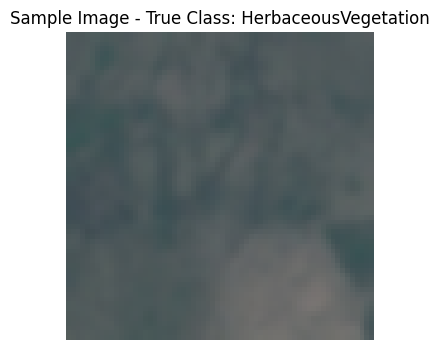

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


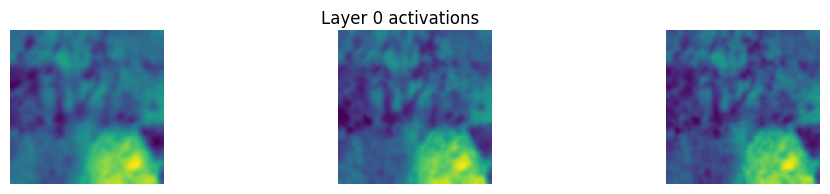

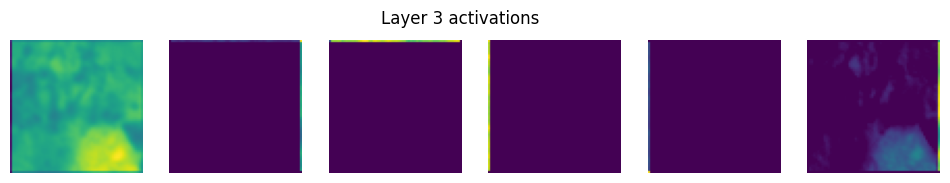

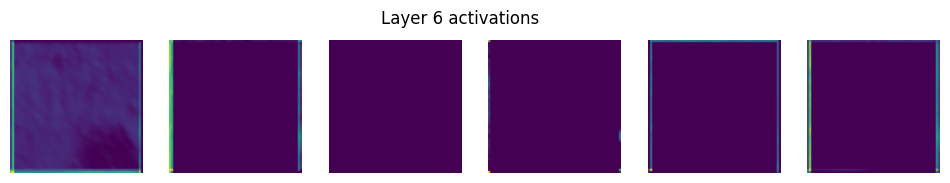

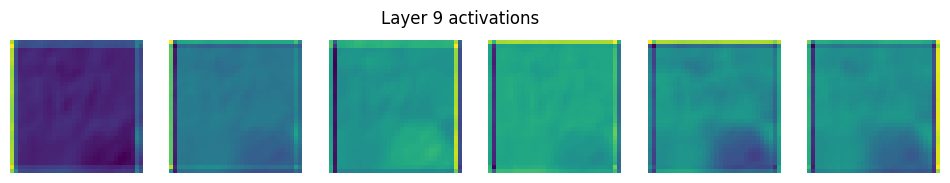

In [ ]:
# Visualize activations from a sample image
if len(X_val) > 0:
    # Select a random validation image
    sample_idx = np.random.randint(0, len(X_val))
    sample_img = X_val[sample_idx:sample_idx+1]  # Keep batch dimension
    sample_class = classes[y_val[sample_idx]]
    
    print(f"Visualizing activations for sample image (True class: {sample_class})")
    
    # Show the original image
    plt.figure(figsize=(4, 4))
    plt.imshow(sample_img[0])
    plt.title(f'Sample Image - True Class: {sample_class}')
    plt.axis('off')
    plt.show()
    
    # Visualize activations from different layers of the improved model
    # Layer indices to visualize (conv layers)
    layer_indices = [0, 3, 6, 9]  # First conv layers from each block
    visualize_activations(improved, sample_img, layer_indices)
else:
    print("No validation data available for activation visualization")

## 17. Results Export and Model Saving

Save trained models, export prediction CSV files, and organize all outputs for submission.

Saved improved predictions to: C:\Users\admin\Downloads\predictions_improved.csv
Improved model saved to: C:\Users\admin\Downloads\loopverse_improved_model.h5


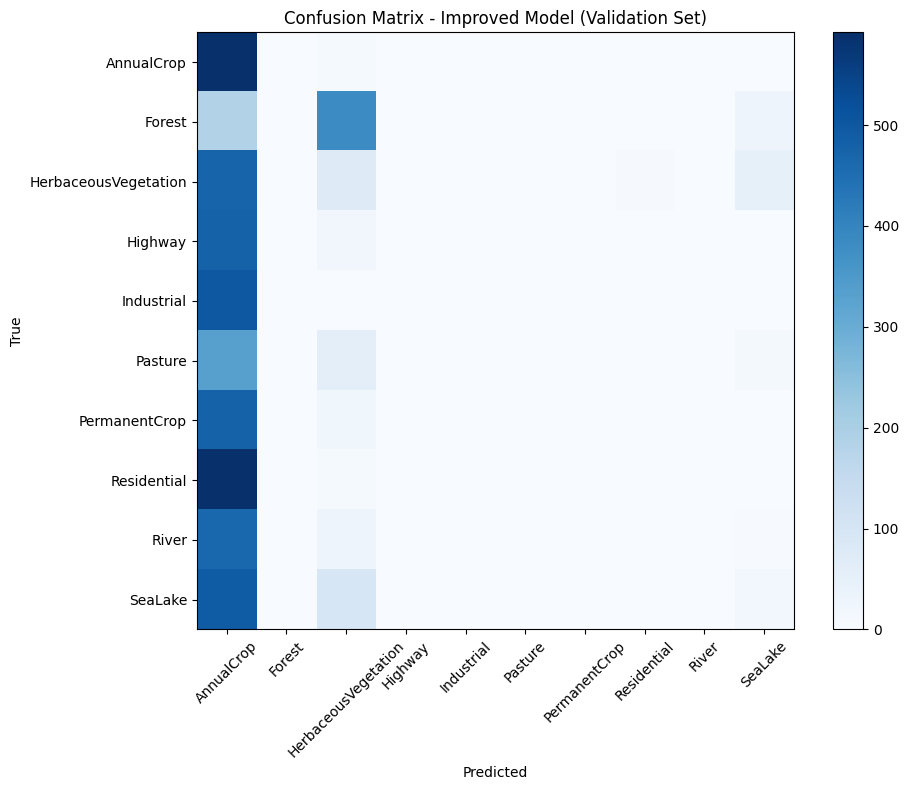

Improved confusion matrix saved to: C:\Users\admin\Downloads\confusion_matrix_improved.png

PIPELINE COMPLETED SUCCESSFULLY!

Files created in C:\Users\admin\Downloads:
📊 predictions_baseline.csv
📊 predictions_improved.csv
🖼️  confusion_matrix_baseline.png
🖼️  confusion_matrix_improved.png
🖼️  confusion_matrix_comparison.png
🤖 loopverse_baseline_model.h5
🤖 loopverse_improved_model.h5
🤖 best_model_baseline.h5
🤖 best_model_improved.h5

📈 Final Results Summary:
Baseline Model Validation Accuracy: 0.0926
Improved Model Validation Accuracy: 0.1259
Improvement: 0.0333

✅ Ready for LoopVerse 2025 submission!


In [ ]:
# Save improved model predictions
df2 = pd.DataFrame({'image_id': paths_val, 'predicted_label': [classes[i] for i in y_pred2]})
csv_out2 = output_dir / 'predictions_improved.csv'
df2.to_csv(csv_out2, index=False)
print(f'Saved improved predictions to: {csv_out2}')

# Save improved model
model_path2 = output_dir / 'loopverse_improved_model.h5'
improved.save(model_path2)
print(f'Improved model saved to: {model_path2}')

# Save individual improved confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm2, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Improved Model (Validation Set)')
plt.colorbar()
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

cm2_path = output_dir / 'confusion_matrix_improved.png'
plt.savefig(cm2_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Improved confusion matrix saved to: {cm2_path}")

# Summary of all generated files
print("\n" + "="*60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nFiles created in {output_dir}:")
print(f"📊 predictions_baseline.csv")
print(f"📊 predictions_improved.csv")
print(f"🖼️  confusion_matrix_baseline.png")
print(f"🖼️  confusion_matrix_improved.png")
print(f"🖼️  confusion_matrix_comparison.png")
print(f"🤖 loopverse_baseline_model.h5")
print(f"🤖 loopverse_improved_model.h5")
print(f"🤖 best_model_baseline.h5")
print(f"🤖 best_model_improved.h5")

print(f"\n📈 Final Results Summary:")
print(f"Baseline Model Validation Accuracy: {final_val_acc:.4f}")
print(f"Improved Model Validation Accuracy: {final_val_acc2:.4f}")
print(f"Improvement: {final_val_acc2 - final_val_acc:.4f}")

print(f"\n✅ Ready for LoopVerse 2025 submission!")